In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
from PIL import  Image
from tqdm.autonotebook import  tqdm
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


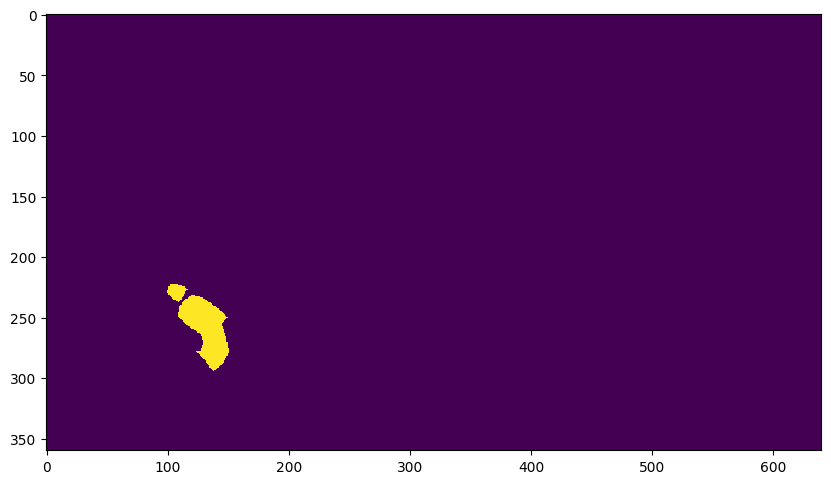

[223 102]
(1, 2)


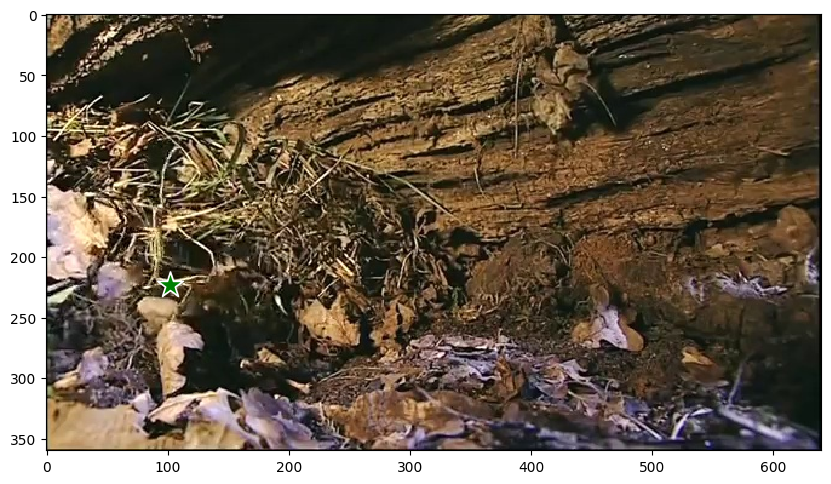

In [2]:
image = cv2.cvtColor(cv2.imread('dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/hedgehog_3/Imgs/00010.jpg'),cv2.COLOR_BGR2RGB)
gt = cv2.imread('dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/hedgehog_3/GT/00010.png',cv2.IMREAD_GRAYSCALE)
# # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# plt.imshow(gt)
# print(np.unique(gt))
# print(gt.shape)
h,w,_ = image.shape
plt.figure(figsize=(10,10))
plt.imshow(gt)
plt.axis('on')
plt.show()
# non_zero_points = np.argwhere(gt!=0)
# input_point = np.array([[non_zero_points[np.random.choice(len(non_zero_points))],
#                         non_zero_points[np.random.choice(len(non_zero_points))]]])

non_zero_points = np.argwhere(gt!=0)
print(non_zero_points[0])
h,w = non_zero_points[0]
# print(random_point)
# x,y = random_point
# input_point = np.array([non_zero_points[np.random.choice(len(non_zero_points))]])
input_point = np.array([[w,h]])
print(input_point.shape)
input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [2]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# predictor.set_image(image)

In [6]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,)

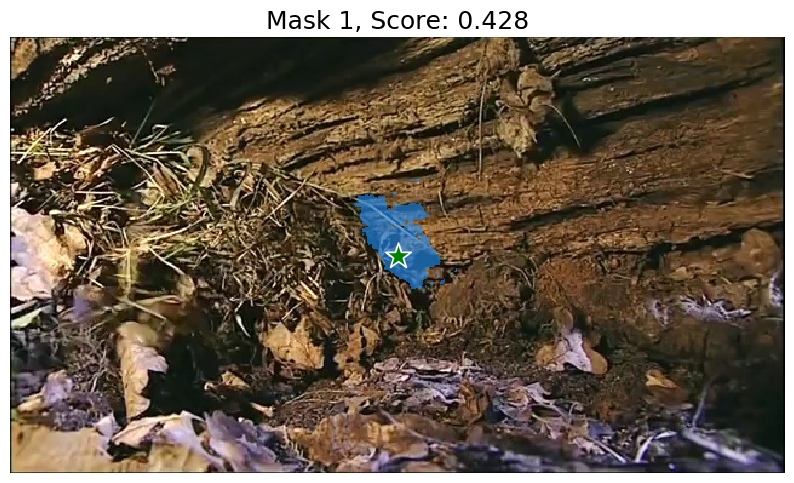

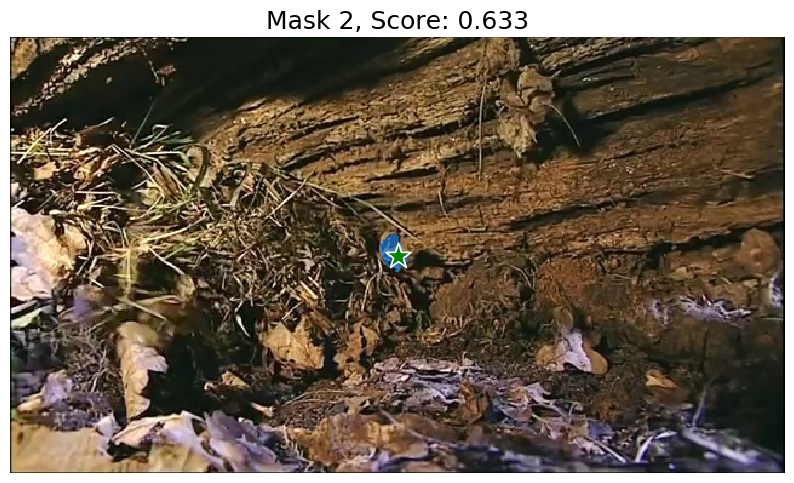

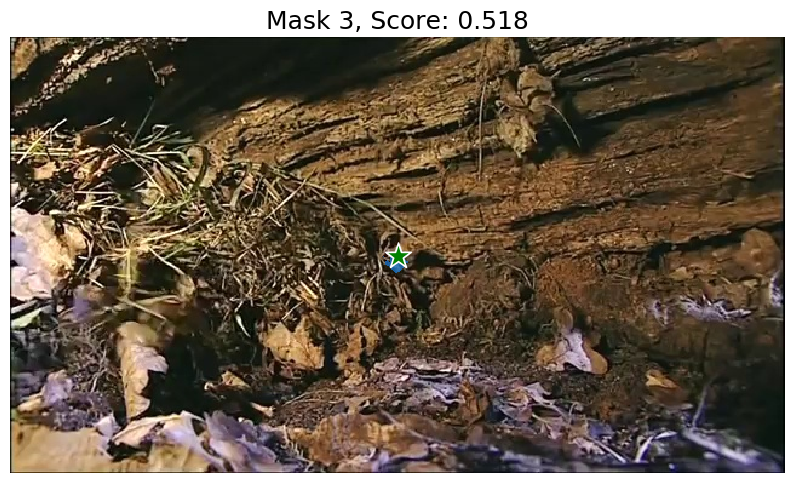

In [37]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

In [3]:
directory = 'dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq'
for i in tqdm(os.listdir(directory)):
    folder_path = os.path.join(directory,i+'/Imgs')
    gt_path =os.path.join(directory,i+'/GT')
    # print(gt_path)
    os.makedirs(directory+'/'+i+'/sam_output',exist_ok=True)
    os.makedirs(directory+'/'+i+'/sam_output_visualistic',exist_ok=True)
    
    for j in tqdm(sorted(os.listdir(folder_path))):

        img_path = os.path.join(folder_path,j)
        # print(img_path[:-15])
        
        image = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)
        gt= cv2.imread(os.path.join(gt_path,j[:5])+".png",cv2.IMREAD_GRAYSCALE)
        h,w = gt.shape
        
        non_zero_points = np.argwhere(gt!=0)
        # print(non_zero_points[0])
        h,w = non_zero_points[2]

        input_point = np.array([[w,h]])
        # print(input_point.shape)
        input_label = np.array([1])

        predictor.set_image(image)
        masks, scores, logits = predictor.predict(
                                point_coords=input_point,
                                point_labels=input_label,
                                multimask_output=True,)

        idx = np.argmax(scores)
        # print(img_path[:-15]+"/sam_output/"+j)
        # plt.imshow(masks[idx],cmap='gray')
        # plt.savefig(img_path[:-15]+"/sam_output/"+j[:-4]+".png")
        # plt.axis('off')
        # plt.close()

        img = Image.fromarray(masks[idx])
        img.save(img_path[:-15]+"/sam_output/"+j[:-4]+".png")

        plt.imshow(image)
        show_mask(masks[idx],plt.gca())
        # show_points(input_point, input_label, plt.gca())
        plt.savefig(img_path[:-15]+"/sam_output_visualistic/"+j[:-4]+".png")
        plt.axis('off')
        plt.close()

        del idx,masks,scores,logits,h,w,non_zero_points

    del folder_path,gt_path
        
        



100%|██████████| 16/16 [05:17<00:00, 19.87s/it]


In [2]:
img1 = cv2.imread('dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00000.png',cv2.IMREAD_GRAYSCALE)
img2 =cv2.imread('dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00000.jpg',cv2.IMREAD_GRAYSCALE)

In [3]:
img1.shape

(720, 1280)

In [4]:
from metrics import  calculate_measures
gt_dir = 'dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/'
sm_dir = 'dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/'

res = calculate_measures(gt_dir,sm_dir,['E-measure','S-measure','Wgt-F','MAE'],save=False)

  3%|▎         | 1/30 [00:00<00:03,  8.39it/s]

dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00095.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00095.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00125.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00125.png


 10%|█         | 3/30 [00:00<00:03,  8.72it/s]

dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00020.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00020.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00050.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00050.png


 17%|█▋        | 5/30 [00:00<00:02,  9.19it/s]

dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00010.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00010.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00080.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00080.png


 23%|██▎       | 7/30 [00:00<00:02,  9.43it/s]

dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00090.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00090.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00045.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00045.png


 30%|███       | 9/30 [00:00<00:02,  9.31it/s]

dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00140.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00140.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00060.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00060.png


 37%|███▋      | 11/30 [00:01<00:02,  9.30it/s]

dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00005.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00005.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00105.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00105.png


 47%|████▋     | 14/30 [00:01<00:01,  9.64it/s]

dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00100.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00100.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00065.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00065.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00040.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00040.png


 53%|█████▎    | 16/30 [00:01<00:01,  9.78it/s]

dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00143.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00143.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00055.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00055.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00085.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00085.png


 63%|██████▎   | 19/30 [00:01<00:01,  9.73it/s]

dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00030.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00030.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00015.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00015.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00075.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00075.png


 73%|███████▎  | 22/30 [00:02<00:00,  9.90it/s]

dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00070.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00070.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00120.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00120.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00135.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00135.png


 87%|████████▋ | 26/30 [00:02<00:00, 10.06it/s]

dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00025.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00025.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00035.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00035.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00130.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00130.png


 93%|█████████▎| 28/30 [00:02<00:00, 10.08it/s]

dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00115.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00115.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00000.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00000.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/00110.png
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/sam_output/00110.png


100%|██████████| 30/30 [00:03<00:00,  9.78it/s]


In [5]:
print(res)

{'E-measure': 0.6430424599211082, 'S-measure': 0.7350399351196935, 'Wgt-F': 0.42321597643454584, 'MAE': 0.02881376591435185}


In [7]:
from metrics import  calculate_measures
directory = 'dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq'
results = []
for i in tqdm(sorted(os.listdir(directory))):
    sm_path = os.path.join(directory,i+'/sam_output/')
    gt_path =os.path.join(directory,i+'/GT/')
    
    res = calculate_measures(gt_path,sm_path,['E-measure','S-measure','Wgt-F','MAE'],save=False)
    print(res)
    print(gt_path)
    results.append(res)


  6%|▋         | 1/16 [00:03<00:46,  3.12s/it]

{'E-measure': 0.6430424599211082, 'S-measure': 0.7350399351196935, 'Wgt-F': 0.42321597643454584, 'MAE': 0.02881376591435185}
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox/GT/


 12%|█▎        | 2/16 [00:06<00:45,  3.26s/it]/home/pratyush/miniconda3/envs/cvpr/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratyush/miniconda3/envs/cvpr/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pratyush/miniconda3/envs/cvpr/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pratyush/miniconda3/envs/cvpr/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/pratyush/miniconda3/envs/cvpr/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret 

{'E-measure': 0.8972931905773086, 'S-measure': 0.8682799847859286, 'Wgt-F': 0.7630512824967557, 'MAE': 0.0011820126488095238}
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/arctic_fox_3/GT/


 19%|█▉        | 3/16 [00:14<00:58,  4.53s/it]

{'E-measure': 0.48490133891323217, 'S-measure': nan, 'Wgt-F': 0.13028183410476055, 'MAE': 0.03601913289573821}
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/black_cat_1/GT/


 25%|██▌       | 4/16 [00:22<01:09,  5.80s/it]

{'E-measure': 0.5046983937862999, 'S-measure': nan, 'Wgt-F': 0.10235497790511051, 'MAE': 0.012669545368975906}
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/copperhead_snake/GT/


 31%|███▏      | 5/16 [00:27<00:58,  5.33s/it]

{'E-measure': 0.5512504481002584, 'S-measure': 0.6083351402185686, 'Wgt-F': 0.15413790709602088, 'MAE': 0.05802471245659722}
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/flower_crab_spider_0/GT/


 38%|███▊      | 6/16 [00:31<00:51,  5.16s/it]

{'E-measure': 0.613357938599232, 'S-measure': 0.5877372939274994, 'Wgt-F': 0.13297438514091658, 'MAE': 0.02449300130208333}
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/flower_crab_spider_1/GT/


 44%|████▍     | 7/16 [00:35<00:41,  4.58s/it]

{'E-measure': 0.39354225079635147, 'S-measure': 0.683315786378964, 'Wgt-F': 0.07822794644971963, 'MAE': 0.023883933738425924}
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/flower_crab_spider_2/GT/


 50%|█████     | 8/16 [00:35<00:27,  3.38s/it]

{'E-measure': 0.48368861260791063, 'S-measure': 0.5492189713260766, 'Wgt-F': 0.13536371491871635, 'MAE': 0.07751215277777777}
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/hedgehog_3/GT/


 56%|█████▋    | 9/16 [00:38<00:21,  3.13s/it]

{'E-measure': 0.6615450178168595, 'S-measure': 0.7200204867739117, 'Wgt-F': 0.4568211309982544, 'MAE': 0.013171571180555557}
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/ibex/GT/


 62%|██████▎   | 10/16 [00:39<00:15,  2.51s/it]

{'E-measure': 0.6136951578180966, 'S-measure': 0.6311867158026931, 'Wgt-F': 0.2026750009991579, 'MAE': 0.0057267795138888885}
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/mongoose/GT/


 69%|██████▉   | 11/16 [00:41<00:11,  2.32s/it]

{'E-measure': 0.7671583602002258, 'S-measure': 0.5644519952106719, 'Wgt-F': 0.136410468444573, 'MAE': 0.021248204441338615}
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/moth/GT/


 75%|███████▌  | 12/16 [00:43<00:08,  2.24s/it]

{'E-measure': 0.8873593816291034, 'S-measure': 0.8050550439627644, 'Wgt-F': 0.6256293478387763, 'MAE': 0.0028554687500000004}
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/pygmy_seahorse_0/GT/


 81%|████████▏ | 13/16 [00:45<00:06,  2.19s/it]

{'E-measure': 0.8890729285459293, 'S-measure': 0.7146058327342363, 'Wgt-F': 0.4808222553347605, 'MAE': 0.007116373697916667}
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/rusty_spotted_cat_0/GT/


 88%|████████▊ | 14/16 [00:46<00:03,  1.86s/it]

{'E-measure': 0.7456327263809965, 'S-measure': 0.7327115110522995, 'Wgt-F': 0.45992622533861827, 'MAE': 0.02282877604166667}
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/sand_cat_0/GT/


 94%|█████████▍| 15/16 [01:02<00:06,  6.07s/it]

{'E-measure': 0.7150648952955853, 'S-measure': nan, 'Wgt-F': 0.2678652414498419, 'MAE': 0.04528375616039426}
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/snow_leopard_10/GT/


100%|██████████| 16/16 [01:06<00:00,  4.15s/it]

{'E-measure': 0.6459043232962631, 'S-measure': 0.5206570573045539, 'Wgt-F': 0.05423781611514029, 'MAE': 0.010932491987179488}
dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/stick_insect_1/GT/


In [8]:
results

[{'E-measure': 0.6430424599211082,
  'S-measure': 0.7350399351196935,
  'Wgt-F': 0.42321597643454584,
  'MAE': 0.02881376591435185},
 {'E-measure': 0.8972931905773086,
  'S-measure': 0.8682799847859286,
  'Wgt-F': 0.7630512824967557,
  'MAE': 0.0011820126488095238},
 {'E-measure': 0.48490133891323217,
  'S-measure': nan,
  'Wgt-F': 0.13028183410476055,
  'MAE': 0.03601913289573821},
 {'E-measure': 0.5046983937862999,
  'S-measure': nan,
  'Wgt-F': 0.10235497790511051,
  'MAE': 0.012669545368975906},
 {'E-measure': 0.5512504481002584,
  'S-measure': 0.6083351402185686,
  'Wgt-F': 0.15413790709602088,
  'MAE': 0.05802471245659722},
 {'E-measure': 0.613357938599232,
  'S-measure': 0.5877372939274994,
  'Wgt-F': 0.13297438514091658,
  'MAE': 0.02449300130208333},
 {'E-measure': 0.39354225079635147,
  'S-measure': 0.683315786378964,
  'Wgt-F': 0.07822794644971963,
  'MAE': 0.023883933738425924},
 {'E-measure': 0.48368861260791063,
  'S-measure': 0.5492189713260766,
  'Wgt-F': 0.135363714918

In [10]:
e_measure = 0
wgt_f= 0
mae = 0
for i in range(len(results)):
    e_measure += results[i]['E-measure']
    wgt_f += results[i]['Wgt-F']
    mae += results[i]['MAE']
    

In [13]:
print(f'E_measure {e_measure/16}')
print(f'Wgt-F {wgt_f/16}')
print(f'mae {mae/16}')

E_measure 0.6560754640177975
Wgt-F 0.28774971944160427
mae 0.024485104929731244
